# Knowledge based question answering (KBQA)


## Introduction
```
Question answering (QA) is a computer science discipline within the fields of information retrieval and natural language processing (NLP), which is concerned with building systems that automatically answer questions posed by humans in a natural language. 
A system for knowledge base question answering was implemented and evaluated its quality for Russian and English languages.

Datasets

1) Simple Questions dataset consists of 108,442 natural language questions, each paired with a corresponding fact from Freebase knowledge base. Each fact is a triple (subject, relation, object) and the answer to the question is always the object. The dataset is divided into training, validation, and test sets with 75,910, 10,845 and 21,687 questions respectively.

2) RuBQ - is the first Russian knowledge base question answering (KBQA) dataset. It consists of 1,500 Russian questions of varying complexity, their English machine translations, SPARQL queries to Wikidata, reference answers, as well as a Wikidata sample of triples containing entities with Russian labels.

3) Wikidata source for entity search

Question answering (QA) addresses the task of returning a precise and concise answer to a natural language question posed by the user. QA received a great deal of attention both in academia and industry. Two main directions within QA are Open-Domain Question Answering (ODQA) and Knowledge Base Question Answering (KBQA). ODQA searches for the answer in a large collection of text documents; the process is often divided into two stages: 1) retrieval of poten- tially relevant paragraphs and 2) spotting an answer span within the paragraph (referred to as machine reading comprehension, MRC ). In contrast, KBQA uses a knowledge base as a source of answers.
```

# Imports

In [ ]:
#!python3 -m spacy download en_core_web_lg

In [ ]:
import spacy


import nltk
import torch
#import torchtext
import numpy as np
import pandas as pd
import json
import numpy as np
import random
import sys
from tqdm import tqdm
import re

import torch
import torch.nn as nn
#from transformers import DistilBertModel, DistilBertTokenizer,BertModel,BertTokenizer
from torch.utils.data import DataLoader

from wikidataintegrator import wdi_core
from wikidata.client import Client
import wikidata
import en_core_web_sm
nlp = en_core_web_sm.load()

from IPython.display import clear_output
import matplotlib.pyplot as plt

import wikidataintegrator
from wikidataintegrator import wdi_core
from wikidata.client import Client
import wikidata
import en_core_web_sm
import nltk
import numpy as np
import json
import multiprocessing as mp
import pickle

import wikidataintegrator
from wikidataintegrator import wdi_core
from wikidata.client import Client
import wikidata
sp_lg = spacy.load('en_core_web_lg')
%matplotlib inline




In [ ]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/MyDrive/NNLP/KBQA_project")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.append(str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Entity Detection
We use NER to get entities, as it works faster than the rest of the solutions. Perhaps we are losing a little in quality, but we have made a choice in favor of time.

Next, we use the obtained entities to find candidates from which answers will be searched later. Triplets consist of 3 entities: 1 is the entity derived from the questions, 2 is the relation, 3 is the entity that is the possible answer to the question.

Next, we combine everything into a function that will pull entities out of the sentence and at the output we will get the emings of candidates for answers and their IDs

Embeddings you can find here:

https://drive.google.com/file/d/1p5FtjxD28XPlPVOBJuJ3wCAxXzZ120nm/view?usp=sharing

https://drive.google.com/file/d/1ioFPghPCJFqxqByqyM1O9zmf1n3HZDG5/view?usp=sharing

In [ ]:
PATH_TO_Q_EMBEDDINGS = "Q_embeddings.json" 
PATH_TO_P_EMBEDDINGS = "P_embeddings.json"

q_embeddings = json.load(open(PATH_TO_Q_EMBEDDINGS))
p_embeddings = json.load(open(PATH_TO_P_EMBEDDINGS))

nlp = en_core_web_sm.load()
client = wikidata.client.Client()

def get_triplets_by_idd(idd):
    '''
    This function returns a list of triples for a given entity by its id
        
        input:  (str) wikidata id, e.x. 'Q2'
        output: (list) list of lists of strings
    '''
    client = wikidata.client.Client()
    entity = client.get(idd, load = True)
    triples = []
    for x in list(entity): 

        prop = client.get(x.id, load = True)
        
        try:
            if type(entity[prop]) is wikidata.entity.Entity:
                res = str(entity[prop].label).lower()
                
            else:
                res = str(entity[prop]).lower()

        except Exception as e:
            try:
                param = str(e).split("unsupported type: ")[1].replace("'",'"')
                d = json.loads(param)
                res = str(d["value"]["amount"]).lower()

            except:
                res = ("BAD_TYPE")
        
        triples.append(res)
    return triples


def get_description_name(idd):

    entity = client.get(idd, load=True)
    name = "None"
    description = "None"
    print(entity)
    try:
        name = entity.data["labels"]["en"]["value"]
        description = entity.data["descriptions"]["en"]["value"]
    except:
        pass
    return name + ", " + description

In [ ]:
def spacy_large_ner(document):
    return [ent.text.strip() for ent in sp_lg(document).ents]

def find_triplets_from_sentence(text):

    sp_lg = spacy.load('en_core_web_lg') 
    nouns = spacy_large_ner(text)
    ids = []
    for noun in nouns:
        id = wdi_core.WDItemEngine.get_wd_search_results(noun)
        ids += id[:1]

    triplets = []
    id_triplents = []
    for id in ids:    
        triplet = get_triplets_by_idd(id)
        for answ in triplet:
            
            idd = wdi_core.WDItemEngine.get_wd_search_results(answ)
            if len(idd)==0:
                continue
            try:
                emb = q_embeddings[idd[0]]
                triplets += [emb]
                id_triplents += [idd[0]]
            except:
                continue
    
    return triplets, id_triplents

In [ ]:
df = pd.read_table("annotated_wd_data_test_answerable.txt", header=None)
pool = mp.Pool(100)
questions = df[3]
results = pool.map(find_triplets_from_sentence, [row for row in questions[:100]])

candidates = []
embeds = []

for emb, cand in results:
    candidates.append(cand)
    embeds.append(embeds)

df_new = pd.DataFrame()
df_new["question"] = questions[:100]
df_new["answer"] = df[2][:100]

with open('test.pkl','wb') as f:
    pickle.dump(embeds, f)
    

# Downloading the dataset


In [ ]:
import json
# Train
json1_file = open('/content/drive/MyDrive/NNLP/KBQA_project/SimpleQuestions1/annotated_wd_data_train1.json')
json1_str = json1_file.read()
json1_data = json.loads(json1_str)
train_embeds=pd.DataFrame(json1_data)
ques_tr=train_embeds.columns
embeds_train=[]
for i in range(train_embeds.shape[1]):
  embeds_train.append(list(train_embeds.iloc[:,i]))
ques_tr=pd.DataFrame([ques_tr,embeds_train]).T
ques_tr.columns=['Question','Answer']

#Val
json1_file = open('/content/drive/MyDrive/NNLP/KBQA_project/SimpleQuestions1/annotated_wd_data_valid1.json')
json1_str = json1_file.read()
json1_data = json.loads(json1_str)
val_embeds=pd.DataFrame(json1_data)
ques_val=val_embeds.columns
embeds_val=[]
for i in range(val_embeds.shape[1]):
  embeds_val.append(list(val_embeds.iloc[:,i]))
ques_val=pd.DataFrame([ques_val,embeds_val]).T
ques_val.columns=['Question','Answer']

#Test
json1_file = open('/content/drive/MyDrive/NNLP/KBQA_project/SimpleQuestions1/annotated_wd_data_test_answerable1.json')
json1_str = json1_file.read()
json1_data = json.loads(json1_str)
test_embeds=pd.DataFrame(json1_data)
ques_test=test_embeds.columns
embeds_test=[]
for i in range(test_embeds.shape[1]):
  embeds_test.append(list(test_embeds.iloc[:,i]))
ques_test=pd.DataFrame([ques_test,embeds_test]).T
ques_test.columns=['Question','Answer']

#Test candidates

test_cand_df=pd.read_csv('/content/drive/MyDrive/NNLP/KBQA_project/test_frame.csv')
embed_cand=pd.read_pickle('/content/drive/MyDrive/NNLP/KBQA_project/test.pkl')

# Creating candidates for answers

In [ ]:
test_cand_df=pd.read_csv('/content/drive/MyDrive/NNLP/KBQA_project/test_frame.csv')
embed_cand=pd.read_pickle('/content/drive/MyDrive/NNLP/KBQA_project/test.pkl')
test_cand_df['candidates_embeds']=embed_cand

new_cand=[]
candidates=test_cand_df['candidates']
for cand in candidates:
    arr = cand.strip('][').split(', ')
    new_arr = []
    for el in arr:
        new_el = el[1:-1]
        new_arr.append(new_el)
    new_cand.append(new_arr)
test_cand_df['candidates']=new_cand


In [ ]:
test_cand_df.columns=['Question', 'Answer', 'candidates', 'candidates_embeds']

# Preprocess Data

In [ ]:
import nltk
from nltk.corpus import stopwords as nltk_stopwords

nltk.download('wordnet')
nltk.download('stopwords')
def clean_text(string):
    string=str(string)
    delimiter='\n'  
    string = string.replace(delimiter, "")

    return string    

for i in range(ques_tr.shape[0]):
  ques_tr.iloc[i,0]=clean_text(ques_tr.iloc[i,0])
for i in range(ques_val.shape[0]):
  ques_val.iloc[i,0]=clean_text(ques_val.iloc[i,0])
for i in range(ques_test.shape[0]):
  ques_test.iloc[i,0]=clean_text(ques_test.iloc[i,0])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Defining the model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from transformers import DistilBertModel, DistilBertTokenizer,BertModel,BertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


class EncoderBERT(nn.Module):
    def __init__(self):
        super(EncoderBERT,self).__init__()
        self.encoder = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

        
    def forward(self,questions):
        q_ids = torch.tensor(questions)
        last_hidden_states = self.encoder(q_ids)[0]
        q_emb = torch.mean(last_hidden_states,dim=1)
        return q_emb
    

# Bert_to_Graph is used to convert bert embeddins to graph embeddings of entities in wikidata

In [ ]:
class Bert_to_Graph(nn.Module):
    def __init__(self,dropout):
        super(Bert_to_Graph,self).__init__()
        self.dropout=dropout
      
        self.nn_layers = nn.ModuleList([nn.Linear(768,768),
                    nn.BatchNorm1d(768),
                    nn.LeakyReLU(),
                    nn.Linear(768,200)])
      
                                
    def block(self,in_features,out_features,dropout):
          block_i=nn.Sequential(
              nn.Linear(in_features,out_features),
              nn.BatchNorm1d(out_features),
              nn.Dropout(p=dropout),
              nn.ReLU())
          return block_i 
        
       
    def final_layer(self,in_features,out_features):
          fin_layer=nn.Linear(in_features,out_features)
          return fin_layer
        
    def forward(self,input):
        x=input
        for i in range(len(self.nn_layers)):
          x=self.nn_layers[i](x)
        return x


# Define Datasets and Dataloaders

In [ ]:
def make_tensors(question,answer):
  tensors=[]
  for i in range(question.shape[0]):
    questions_ids=torch.tensor(tokenizer.encode(question[i], max_length=200, add_special_tokens=True,pad_to_max_length=True))
    embed_tensors=torch.tensor(answer[i])
    tensors.append((questions_ids,embed_tensors))
  return tensors
  

In [ ]:
def make_tensors_test(question):
  tensors=[]
  for i in range(question.shape[0]):
    questions_ids=torch.tensor(tokenizer.encode(question[i], max_length=200, add_special_tokens=True,pad_to_max_length=True))
    tensors.append(questions_ids)
  return tensors

In [ ]:
train_tensors=make_tensors(ques_tr['Question'],ques_tr['Answer'])
val_tensors=make_tensors(ques_val['Question'],ques_val['Answer'])
test_tensors=make_tensors_test(test_cand_df['Question'])

train_loader=DataLoader(train_tensors,batch_size=128, shuffle=True)
val_loader=DataLoader(val_tensors,batch_size=1024, shuffle=True)
test_loader=DataLoader(test_tensors,batch_size=1, shuffle=False)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Define models

In [ ]:
torch.cuda.empty_cache()
encoder = EncoderBERT().to(device)
bert2graph=Bert_to_Graph(0.3).to(device)


ADAM=True
if ADAM==True:
  optimizer1 = torch.optim.Adam(bert2graph.parameters(),lr=0.001)
  optimizer2 = torch.optim.Adam(encoder.parameters(),lr=0.0001)
else:
  optimizer1=torch.optim.RAdam(bert2graph.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
  optimizer2=torch.optim.RAdam(encoder.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=6, gamma=0.1)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Train the model


In [ ]:
from tqdm.notebook import tqdm_notebook
loss_train=[]
loss_test=[]
similarity=[]

num_epoch=20
iterator = 0

for epoch in range(num_epoch):
    
    for X, y in tqdm_notebook(train_loader):
        bert2graph.train()
        X_device=X.to(device)
        y_device=y.to(device)
        
        y_pred = bert2graph(encoder(X_device))
        loss = nn.MSELoss()(y_device,y_pred)
        loss_train.append(loss.item())
        loss.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        if iterator > 100:
          optimizer2.step()
        optimizer2.zero_grad()
        
        if iterator % 50 == 0:
            bert2graph.eval()
            with torch.no_grad():
                for X, y in val_loader:
                    X_device=X.to(device)
                    y_device=y.to(device)
                    y_pred = bert2graph(encoder(X_device))
                    loss = nn.MSELoss()(y_device,y_pred)
                    loss_test.append(loss.item())
                    similarity.append(torch.mean(torch.cosine_similarity(y_device,y_pred)).item())
            plt.semilogy(loss_train,color='green')
            plt.grid()
            plt.title("train_loss")
            plt.show()
            
            plt.semilogy(loss_test,color='green')
            plt.grid()
            plt.title("test_loss")
            plt.show()

            plt.plot(similarity,color='green')
            plt.grid()
            plt.title("similarity")
            plt.show()
        clear_output(wait=True)
        iterator += 1
    scheduler.step()
    print(f'{epoch+1}-th EPOCH HAS FINISHED')

10-th EPOCH HAS FINISHED


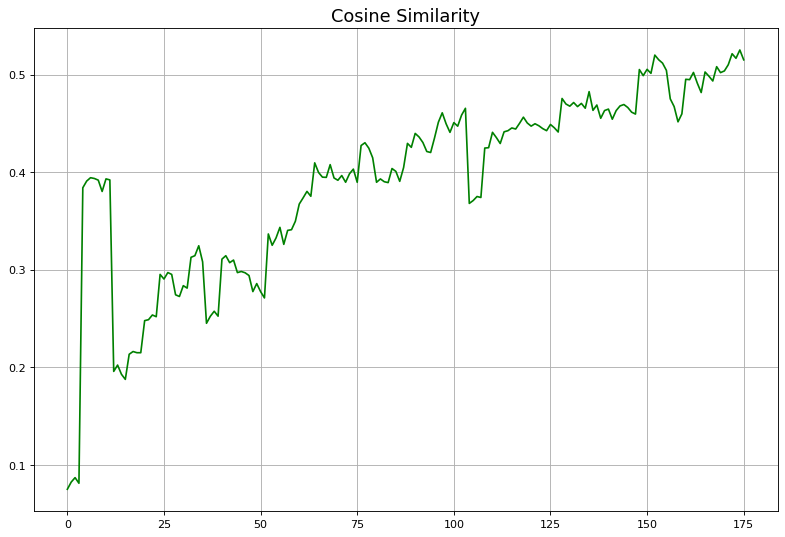

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=80)
plt.plot(similarity,color='green')
plt.grid()
plt.title("Cosine Similarity",fontsize=16)
plt.show()

In [ ]:
torch.save(bert2graph.state_dict(), f'bert2graph_{num_epoch}.ckpt')
torch.save(encoder.state_dict(), f'encoder_{num_epoch}.ckpt')


# Test inference

In [ ]:
new_cand=[]
candidates=test_cand_df['candidates']
for cand in candidates:
    arr = cand.strip('][').split(', ')
    new_arr = []
    for el in arr:
        new_el = el[1:-1]
        new_arr.append(new_el)
    new_cand.append(new_arr)
test_cand_df['candidates']=len(new_cand)

# Checkpoints are in the checpoints folder:
https://drive.google.com/drive/u/0/folders/1qLwfoN_-dnox5B8zY5q33dhUA0gGRV7O

In [ ]:
bert2graph=Bert_to_Graph(0.3)

path_b2g=''
bert2graph.load_state_dict(torch.load('/content/drive/MyDrive/NNLP/KBQA_project/checkpoints/bert2graph_50.ckpt'))
bert2graph.to(device)
bert2graph.eval()

encoder=EncoderBERT().to(device)

path_enc=''
encoder.load_state_dict(torch.load('/content/drive/MyDrive/NNLP/KBQA_project/checkpoints/encoder50.ckpt'))
encoder.to(device)
encoder.eval()

                    

In [ ]:
test_answers=[]
with torch.no_grad():
                for X, y in test_loader:
                    X_device=X.to(device)
                    y_device=y.to(device)
                    y_pred = bert2graph(encoder(X_device))
                    test_answers.append(y_pred)

In [ ]:
test_answers=[]
best_candidate_id=[]
i=0
with torch.no_grad():
  for X in test_loader:
      X_device=X.to(device)

      question_pred = bert2graph(encoder(X_device))
      test_answers.append(question_pred)
      cosines=[]
      for j in range(0,len(test_cand_df['candidates_embeds'][i])):
        print()
        if test_cand_df['candidates_embeds'][i][j]=='nan':
          pass
        else:
          cand_embed_j=torch.tensor(test_cand_df['candidates_embeds'][i][j])
          cosines.append(torch.cosine_similarity(cand_embed_j ,question_pred.cpu()))
      if cosines == []:
        best_candidate_id.append('nan')
      else:


        best_candidate=np.argmax(cosines)
        best_candidate_id.append(test_cand_df['candidates'][i][best_candidate])
      i+=1


In [ ]:
(test_cand_df['Answer']==best_candidate_id).sum()


15

In [ ]:
def get_description_name(idd):
    client = wikidata.client.Client()
    entity = client.get(idd, load=True)
    name = "None"
    description = "None"
    print(entity)
    try:
        name = entity.data["labels"]["en"]["value"]
        description = entity.data["descriptions"]["en"]["value"]
    except:
        pass
    return name + ", " + description

In [ ]:
for i in range(20, 40):
  print('Question:')
  print(test_cand_df['Question'][i])
  print('Answer:')
  print(get_description_name(best_candidate_id[i]))

Question:
what's the name of an Australian rock and roll
Answer:
<wikidata.entity.Entity Q185278 'News Corporation'>
News Corporation, defunct media corporation (1979–2013)
Question:
what is the category of the celestial object 1241 dysona
Answer:
<wikidata.entity.Entity Q577 'year'>
year, estimated period of time for the Earth's orbit around the Sun and observed at a fixed geographic point (averaging 365.24 days); base later modified to define or adjust various calendars
Question:
What is a type of gameplay available to gamers playing custom robo v2
Answer:
<wikidata.entity.Entity nan>
None, None
Question:
What's an example of a romance film
Answer:
<wikidata.entity.Entity nan>
None, None
Question:
where was shigeyasu suzuki's place of birth
Answer:
<wikidata.entity.Entity nan>
None, None
Question:
which nationality is yonatan rozen
Answer:
<wikidata.entity.Entity Q801 'Israel'>
Israel, sovereign state in the Middle East
Question:
which indian city was fazil born in
Answer:
<wikidata.

In [ ]:
s=0
for i in range(len(best_candidate_id)):
  if best_candidate_id[i]=='nan':
    s+=1


print(f'Test accuracy is { 15/(100-44)*100}%')

Test accuracy is 26.785714285714285%


In [ ]:
new_cand=[]
candidates=test_cand_df['candidates']
for cand in candidates:
    arr = cand.strip('][').split(', ')
    new_arr = []
    for el in arr:
        new_el = el[1:-1]
        new_arr.append(new_el)
    new_cand.append(new_arr)
test_cand_df['candidates']=len(new_cand)